How many of the checkins have descriptions for the beer?

In [1]:
import numpy as np
import pandas as pd


In [405]:
descrips = pd.read_csv('descriptions.csv', nrows=1)
descrips

,beer_id,beer_description
0,2095023,To create a recipe so tropical and fruity with...


In [406]:
descrips = pd.read_csv('descriptions.csv')
print(len(descrips), descrips.beer_id.nunique())

114347 114347


And how many of all the checkins have descriptions?

In [407]:
checkins = pd.read_csv('comboframe.csv', usecols=['beer_id'])

In [408]:
len(pd.merge(checkins, descrips, how='inner'))

1531277

In [409]:
checkins = pd.read_csv('comboframe.csv', usecols=['beer_id', 'rating_user',
                                                  'rating_global', 'user_id',
                                                  'abv', 'brewery_name', 'beer_name'])

In [410]:
checkins.shape

(2061965, 7)

In [411]:
checkins.drop_duplicates(subset=['beer_id', 'user_id'], inplace=True)

In [412]:
checkins.shape

(1894852, 7)

In [413]:
checkins = checkins.merge(descrips, how='inner')
checkins.shape

(1394388, 8)

In [414]:
checkins.head()

,beer_id,user_id,rating_user,brewery_name,beer_name,rating_global,abv,beer_description
0,2095023,3340203,3.75,Stone Brewing,Stone Scorpion Bowl IPA,3.73789,7.5,To create a recipe so tropical and fruity with...
1,2095023,2166716,3.50,Stone Brewing,Stone Scorpion Bowl IPA,3.73789,7.5,To create a recipe so tropical and fruity with...
2,2095023,2607740,3.50,Stone Brewing,Stone Scorpion Bowl IPA,3.73789,7.5,To create a recipe so tropical and fruity with...
3,2095023,1040951,3.50,Stone Brewing,Stone Scorpion Bowl IPA,3.73789,7.5,To create a recipe so tropical and fruity with...
4,2095023,1338056,3.25,Stone Brewing,Stone Scorpion Bowl IPA,3.73789,7.5,To create a recipe so tropical and fruity with...


In [415]:
checkins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1394388 entries, 0 to 1394387
Data columns (total 8 columns):
beer_id             1394388 non-null int64
user_id             1394388 non-null int64
rating_user         1394388 non-null float64
brewery_name        1394388 non-null object
beer_name           1394388 non-null object
rating_global       1369092 non-null float64
abv                 1394388 non-null float64
beer_description    1394388 non-null object
dtypes: float64(3), int64(2), object(3)
memory usage: 95.7+ MB


In [416]:
# cut the non-globally rated, which are only 2% of the data
checkins.dropna(subset=['rating_global'], axis=0, inplace=True)

In [417]:
checkins.shape

(1369092, 8)

In [418]:
sum(checkins.rating_global == 0)

2488

In [419]:
# get rid of those, too
checkins = checkins[checkins.rating_global > 0]
checkins.shape

(1366604, 8)

### Let's try to find which particular words tend to align with each rater's tastes

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split

In [420]:
cv = CountVectorizer(stop_words='english', min_df=20, max_df=0.57, binary=True)

First, without regards to specific users, how well do the words predict the global rating?

In [424]:
by_beer = checkins.groupby('beer_id')

descrips['abv'] = descrips.beer_id.map(dict(by_beer['abv'].mean()))
descrips['rating_global'] = descrips.beer_id.map(dict(by_beer['rating_global'].mean()))

In [426]:
checkins.set_index('beer_id', inplace=True)

In [428]:
droppers = descrips.rating_global.isna()
sum(droppers)

1377

In [429]:
descrips = descrips[~droppers]
descrips.shape

(112970, 4)

In [433]:
checkins.head()

,beer_id,user_id,rating_user,brewery_name,beer_name,rating_global,abv,beer_description
0,2095023,3340203,3.75,Stone Brewing,Stone Scorpion Bowl IPA,3.73789,7.5,To create a recipe so tropical and fruity with...
1,2095023,2166716,3.50,Stone Brewing,Stone Scorpion Bowl IPA,3.73789,7.5,To create a recipe so tropical and fruity with...
2,2095023,2607740,3.50,Stone Brewing,Stone Scorpion Bowl IPA,3.73789,7.5,To create a recipe so tropical and fruity with...
3,2095023,1040951,3.50,Stone Brewing,Stone Scorpion Bowl IPA,3.73789,7.5,To create a recipe so tropical and fruity with...
4,2095023,1338056,3.25,Stone Brewing,Stone Scorpion Bowl IPA,3.73789,7.5,To create a recipe so tropical and fruity with...


In [432]:
descrips.head()

,beer_id,beer_description,abv,rating_global
0,2095023,To create a recipe so tropical and fruity with...,7.5,3.73789
1,2734572,NEW TRADITIONS CALL FOR NEW HOLIDAYS AND NEW H...,9.0,3.87873
2,1044097,Stone Ruination IPA was the first full-time br...,8.5,4.01290
3,1070,"Made with Highly roasted malted barley, and pl...",9.9,3.91420
4,490277,Note: Swami's IPA is brewed and distributed fr...,6.8,3.84851


In [442]:
descrips['brewery_name'] = descrips.beer_id.map(dict(checkins.groupby('beer_id')['brewery_name'].max(key=len)))

In [443]:
descrips['beer_name'] = descrips.beer_id.map(dict(checkins.groupby('beer_id')['beer_name'].max(key=len)))

In [444]:
descrips.head()

,beer_id,beer_description,abv,rating_global,brewery_name,beer_name
0,2095023,To create a recipe so tropical and fruity with...,7.5,3.73789,Stone Brewing,Stone Scorpion Bowl IPA
1,2734572,NEW TRADITIONS CALL FOR NEW HOLIDAYS AND NEW H...,9.0,3.87873,Ritual Brewing Company,Oil Rig
2,1044097,Stone Ruination IPA was the first full-time br...,8.5,4.01290,Stone Brewing,Stone Ruination Double IPA 2.0
3,1070,"Made with Highly roasted malted barley, and pl...",9.9,3.91420,Lagunitas Brewing Company,Imperial Stout
4,490277,Note: Swami's IPA is brewed and distributed fr...,6.8,3.84851,Pizza Port Brewing Company,Swami's IPA


In [445]:
descrips['beer_description'] = descrips.brewery_name + ' ' + descrips.beer_name + ' ' + descrips.beer_description

In [446]:
descrips.head()

,beer_id,beer_description,abv,rating_global,brewery_name,beer_name
0,2095023,Stone Brewing Stone Scorpion Bowl IPA To creat...,7.5,3.73789,Stone Brewing,Stone Scorpion Bowl IPA
1,2734572,Ritual Brewing Company Oil Rig NEW TRADITIONS ...,9.0,3.87873,Ritual Brewing Company,Oil Rig
2,1044097,Stone Brewing Stone Ruination Double IPA 2.0 S...,8.5,4.01290,Stone Brewing,Stone Ruination Double IPA 2.0
3,1070,Lagunitas Brewing Company Imperial Stout Made ...,9.9,3.91420,Lagunitas Brewing Company,Imperial Stout
4,490277,Pizza Port Brewing Company Swami's IPA Note: S...,6.8,3.84851,Pizza Port Brewing Company,Swami's IPA


In [447]:
vecs = cv.fit_transform(descrips.beer_description)
vecs.shape

(112970, 9517)

In [460]:
vecs = np.concatenate((vecs.toarray(), np.expand_dims((descrips.abv.values / 10.0), -1)), axis=1)

In [462]:
from scipy.sparse import csr_matrix

In [463]:
vecs = csr_matrix(vecs)

In [228]:
model = SGDRegressor(penalty='elasticnet', early_stopping=True, validation_fraction=0.1, 
                     random_state=0, max_iter=500, tol=None, l1_ratio=0.15)

In [229]:
trainX, testX, trainY, testY = train_test_split(vecs, descrips.rating_global, test_size=0.05, random_state=0)

In [230]:
trainX.shape

(107321, 7425)

In [231]:
model.fit(trainX, trainY.values)

/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=True, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=500,
       n_iter=None, n_iter_no_change=5, penalty='elasticnet', power_t=0.25,
       random_state=0, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [232]:
preds = model.predict(testX)

In [233]:
print(max(preds), min(preds))

4.67355264687 2.94556705536


In [234]:
preds = np.clip(preds, 0.25, 5) # possible ratings are 0.25 to 5
diffs = preds - testY
sumsq = np.dot(diffs, diffs)
rmse = np.sqrt(sumsq / len(diffs))
rmse

0.2101099835253307

How does a simple global mean of all training beers perform as a guess?

In [198]:
# Use the mean of the training set
errors = testY - trainY.mean()
sumsqerr = np.dot(errors, errors)
rmse = np.sqrt(sumsqerr / len(errors))
rmse

0.28527865119061402

In [199]:
# vs. peeking by using the mean of all global ratings in the train and test sets combined
errors = testY - descrips.rating_global.mean()
sumsqerr = np.dot(errors, errors)
rmse = np.sqrt(sumsqerr / len(errors))
rmse

0.28527538451367385

In [235]:
print(list(zip(preds[:22], testY[:22])))

[(3.4825868640193778, 3.56213), (3.9518020145291661, 4.21571), (3.8870596211520216, 4.077039999999999), (3.7722770464012245, 3.47297), (3.8549491909438274, 4.3338199999999985), (3.9474416850096095, 4.235150000000001), (4.0204725448669141, 3.8882199999999996), (4.0774886871238785, 4.0481300000000005), (3.9148055414477065, 4.00488), (3.7643488802080189, 3.96849), (3.6751454780801565, 3.536460000000002), (4.5156955416427174, 4.46966), (3.945871716567261, 4.101560000000003), (4.1505545119720519, 3.8046899999999995), (3.808455490322185, 3.67222), (3.6799362349346438, 3.27376), (3.5870880684370912, 3.5608800000000005), (3.8308689661251378, 3.786669999999994), (3.6431751340834899, 3.8661300000000014), (3.678309617954771, 3.50909), (4.1305744345066095, 3.95489), (3.7683018424151791, 3.64267)]


In [201]:
import matplotlib.pyplot as plt
%matplotlib inline

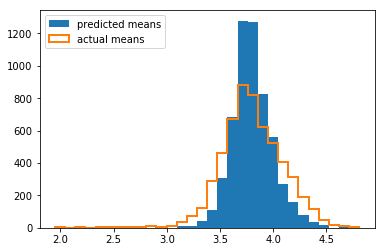

In [236]:
# make everything share same bins (StackO. 23617129)
bins = np.histogram(np.hstack((preds, testY.values)), bins=30)[1]
plt.hist(preds, bins, label='predicted means')
plt.hist(testY, bins, histtype='step', lw=2, label='actual means')
plt.legend();

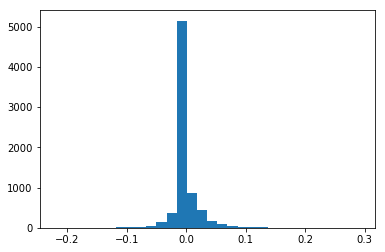

In [237]:
plt.hist(model.coef_, bins=30);

In [238]:
len(model.coef_)

7425

In [239]:
influencers = sorted(enumerate(model.coef_), key=lambda x: abs(x[1]), reverse=True)

In [240]:
influencers[:22]

[(4301, 0.29095082627849705),
 (2597, 0.24961489009358373),
 (7184, 0.23332196409831532),
 (1101, -0.22040684215971354),
 (5083, -0.22012820165455399),
 (4257, 0.21690056616767114),
 (3653, -0.21388289465033022),
 (5153, 0.2082593484907424),
 (1635, -0.2060263270513582),
 (3844, 0.20600328767429829),
 (2, 0.20533489016441253),
 (2932, -0.18002955590721237),
 (1461, -0.17619005213785369),
 (6941, -0.16994482286906312),
 (803, -0.16366888862820955),
 (7413, -0.15018919898213579),
 (6745, 0.14700742201371553),
 (6474, 0.14008345744322809),
 (6886, 0.13869011518502336),
 (7214, 0.13816254524827523),
 (4272, -0.13619947186086548),
 (1810, 0.13570757667929384)]

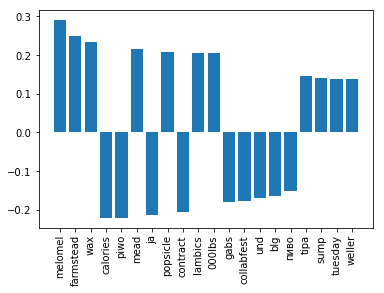

In [261]:
topX = 20
plt.bar(np.arange(topX), [(i[1]) for i in influencers[:topX]])
plt.xticks(np.arange(topX), [cv.get_feature_names()[i[0]] for i in influencers[:topX]], rotation='vertical');

In [273]:
descrips.groupby(descrips.beer_description.str.lower().str.contains('melomel'))['rating_global'].mean()

beer_description
False    3.802049
True     4.395147
Name: rating_global, dtype: float64

In [272]:
descrips.groupby(descrips.beer_description.str.lower().str.contains('calories'))['rating_global'].mean()

beer_description
False    3.802783
True     3.299480
Name: rating_global, dtype: float64

In [473]:
# for each checkin, how much did the user rate the beer better or worse than rest of world?
checkins['beer_bias'] = checkins.rating_user - checkins.rating_global

In [474]:
# use that new column to also make a column that shows the user's overall "generosity" or lack thereof
userbiasdict = dict(checkins.groupby('user_id')['beer_bias'].mean())
checkins['user_bias'] = checkins.user_id.map(userbiasdict)
# and then see how much each rating deviates from that user's baseline bias/generosity
checkins['user_pref'] = checkins.beer_bias - checkins.user_bias

In [475]:
checkins.head()

,beer_id,user_id,rating_user,brewery_name,beer_name,rating_global,abv,beer_description,beer_bias,user_bias,user_pref
0,2095023,3340203,3.75,Stone Brewing,Stone Scorpion Bowl IPA,3.73789,7.5,To create a recipe so tropical and fruity with...,0.01211,0.167938,-0.155828
1,2095023,2166716,3.50,Stone Brewing,Stone Scorpion Bowl IPA,3.73789,7.5,To create a recipe so tropical and fruity with...,-0.23789,-0.663801,0.425911
2,2095023,2607740,3.50,Stone Brewing,Stone Scorpion Bowl IPA,3.73789,7.5,To create a recipe so tropical and fruity with...,-0.23789,-0.207602,-0.030288
3,2095023,1040951,3.50,Stone Brewing,Stone Scorpion Bowl IPA,3.73789,7.5,To create a recipe so tropical and fruity with...,-0.23789,-0.078888,-0.159002
4,2095023,1338056,3.25,Stone Brewing,Stone Scorpion Bowl IPA,3.73789,7.5,To create a recipe so tropical and fruity with...,-0.48789,-0.027114,-0.460776


Try training a regressor on each user with over a certain threshold of ratings in the descriptions Frame

In [476]:
bigs = checkins.groupby('user_id').size() > 100

In [477]:
sum(bigs)

6277

In [478]:
freqs = checkins[checkins.user_id.map(bigs)]
len(freqs)

868621

In [479]:
freqs.user_id.nunique()

6277

In [468]:
descrips.reset_index(inplace=True)
descrips.index

RangeIndex(start=0, stop=112970, step=1)

In [469]:
# now the descrips/vecs index can be looked up for each beer_id
beer_id_to_vecs_index = dict(zip(descrips.beer_id, descrips.index))

In [548]:
user_gen = (user for user in freqs.user_id.unique())

In [471]:
model = SGDRegressor(penalty='elasticnet', early_stopping=True, validation_fraction=0.1, 
                     random_state=0, max_iter=500, tol=1e-4, l1_ratio=0.15)

In [492]:
rmses = []
for _ in range(1000):
    u = next(user_gen)
    udf = freqs[freqs.user_id == u]    
    vi = udf.beer_id.map(beer_id_to_vecs_index)

    xtrain, xtest, ytrain, ytest = train_test_split(vecs[vi, :],
                                                    udf.user_pref.values,
                                                    test_size = 0.1, random_state=0)
    model.fit(xtrain, ytrain)
    preds = model.predict(xtest)
    diffs = preds - ytest
    sumsq = np.dot(diffs, diffs)
    rmse = np.sqrt(sumsq / len(diffs))
    rmses.append(rmse)

/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Applica

In [403]:
# WITH JUST DESCRIPS, NO ABV, NO BREWERYNAME, NO BEERNAME, FIRST 1000 USERS
np.mean(rmses)

0.41770131939694782

While that's effective, if we're going to train a model for each user, we might as well add the brewery name into the bag of words, and feature the a.b.v. as well.

In [481]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/10.0, FIRST 1000 USERS
np.mean(rmses)

0.41045456724343349

In [482]:
# how much of a factor was abv for the last user? 
model.coef_[-1]

0.029312253664937806

In [484]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/10.0, SECOND 1000 USERS
np.mean(rmses)

0.41219801463392686

In [486]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/10.0, THIRD 1000 USERS
np.mean(rmses)

0.40342371577009351

In [488]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/10.0, FOURTH 1000 USERS
np.mean(rmses)

0.39471921597581955

In [491]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/10.0, FIFTH 1000 USERS
np.mean(rmses)

0.40582003370423486

In [493]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/10.0, SIXTH 1000 USERS
np.mean(rmses)

0.36608485008657315

Try different min and max doc_freqs:

In [563]:
cv = CountVectorizer(stop_words='english', min_df=8, max_df=0.67, binary=True)
vecs = cv.fit_transform(descrips.beer_description)
vecs.shape

(112970, 17250)

In [564]:
vecs = hstack([vecs, descrips.abv.values[:, np.newaxis] / 5.0])

In [565]:
vecs = csr_matrix(vecs)

In [566]:
vecs.shape

(112970, 17251)

In [567]:
model = SGDRegressor(penalty='elasticnet', early_stopping=True, validation_fraction=0.1, 
                     random_state=0, max_iter=500, tol=1e-4, l1_ratio=0.15)

In [544]:
from tqdm import tqdm

In [568]:
rmses = []
for _ in tqdm(range(1000)):
    u = next(user_gen)
    udf = freqs[freqs.user_id == u]    
    vi = udf.beer_id.map(beer_id_to_vecs_index)

    xtrain, xtest, ytrain, ytest = train_test_split(vecs[vi, :],
                                                    udf.user_pref.values,
                                                    test_size = 0.1, random_state=0)
    model.fit(xtrain, ytrain)
    preds = model.predict(xtest)
    diffs = preds - ytest
    sumsq = np.dot(diffs, diffs)
    rmse = np.sqrt(sumsq / len(diffs))
    rmses.append(rmse)

  2%|▏         | 19/1000 [00:13<11:25,  1.43it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  2%|▏         | 22/1000 [00:15<10:28,  1.56it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  2%|▏         | 23/1000 [00:16<11:40,  1.39it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  3%|▎         | 29/1000 [00:20<10:35,  1.53it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/l

In [531]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/10.0, wider min-max_df, FIRST 1000 USERS
np.mean(rmses)

0.40935367156602692

In [533]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/10.0, wider min-max_df, SECOND 1000 USERS
np.mean(rmses)

0.41102899786202451

In [551]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/5.0, wider min-max_df, THIRD 1000 USERS
np.mean(rmses)

0.40099016637930346

In [554]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/2.0, wider min-max_df, FOURTH 1000 USERS
np.mean(rmses)

0.39267224585736399

abv / 5.0 worked slightly better than abv / 2.0

In [562]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/5.0, 10-0.8 min-max_df, FIFTH 1000 USERS
np.mean(rmses)

0.40347976746241548

In [569]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/5.0, 8-0.67 min-max_df, SIXTH 1000 USERS
np.mean(rmses)

0.3640813027042098

TODO -- make categorical features for beer style and append them to the trainers

Also, something that should be calculated is the user mean bias (mean of the beer biases by user) ON THE TRAIN DATA ONLY

And the effect of shrinking the min user ratings from 100 to lower